In [1]:
# Carrega a extensão
%load_ext watermark

# Lista TODOS os pacotes instalados (via pip) + metadados
%watermark -d -t -m -v
!pip list  # Exibe a lista completa de pacotes

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.36.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 6.1.0-34-amd64
Machine     : x86_64
Processor   : 
CPU cores   : 2
Architecture: 64bit

Package                   Version
------------------------- --------------
absl-py                   2.2.0
aiohappyeyeballs          2.6.1
aiohttp                   3.11.18
aiosignal                 1.3.2
anyio                     4.9.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 3.0.0
astunparse                1.6.3
async-lru                 2.0.5
async-timeout             5.0.1
attrs                     25.3.0
babel                     2.17.0
beautifulsoup4            4.13.4
bleach                    6.2.0
blinker                   1.9.0
Brotli                    1.1.0
cached-property           1.5.2
cachetools                5.5.2
certifi                   2025.4.26
cf

In [2]:
# Imports e configurações

import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imutils import paths
import imutils
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

2025-05-15 01:04:29.471199: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Carregamento das imagens (Label pelo nome do arquivo)

imagens_treino = "./dados/treino/"

imagens = []
labels = []

# Lista todos os caminhos das imagens
imagePaths = sorted(list(paths.list_images(imagens_treino)))
random.seed(42)
random.shuffle(imagePaths)

for imagePath in imagePaths:
    # Leitura e redimensionamento
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (40, 40))
    image = img_to_array(image)
    imagens.append(image)
    
    # Extrai o label do nome do arquivo (ex: "imagem_pos.jpg")
    filename = imagePath.split(os.path.sep)[-1]  # Pega o nome do arquivo
    if "pos" in filename.lower():
        label = 1
    elif "neg" in filename.lower():
        label = 0
    else:
        raise ValueError(f"Arquivo {filename} não contém 'pos' ou 'neg' no nome!")
    labels.append(label)

# Normalização
imagens = np.array(imagens, dtype="float32") / 255.0
labels = np.array(labels)

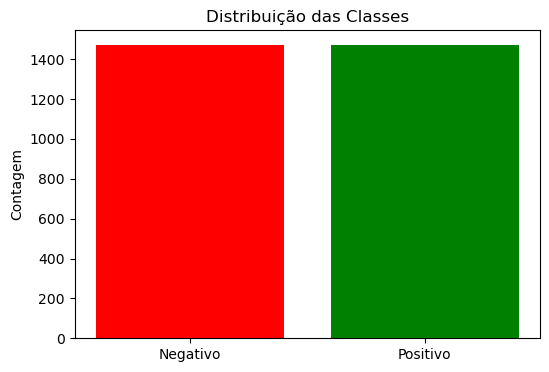

In [4]:
# Análise de distribuição das classes

plt.figure(figsize=(6, 4))
plt.bar(["Negativo", "Positivo"], [np.sum(labels == 0), np.sum(labels == 1)], color=["red", "green"])
plt.title("Distribuição das Classes")
plt.ylabel("Contagem")
plt.show()

In [5]:
# Pré-processamento

# Divisão treino/teste
(x_treino, x_teste, y_treino, y_teste) = train_test_split(imagens, labels, test_size=0.25, random_state=42)

# One-Hot Encoding
y_treino = to_categorical(y_treino, num_classes=2)
y_teste = to_categorical(y_teste, num_classes=2)

# Data Augmentation
aug = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

# Pesos para classes desbalanceadas (ajuste conforme a distribuição)
class_weights = {0: 1, 1: 5}  # Exemplo: classe "pos" tem peso 5x maior

In [6]:
# Construção de modelo

def build_improved_cnn(width, height, depth, classes):
    model = Sequential()
    input_shape = (height, width, depth)
    
    # Bloco Convolucional 1
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Bloco Convolucional 2
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Bloco Convolucional 3
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Camadas Densas
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    
    # Saída
    model.add(Dense(classes, activation="softmax"))
    
    return model

# Hyperparâmetros
EPOCHS = 50
LR = 1e-4
BATCH_SIZE = 32

# Compilação
model = build_improved_cnn(40, 40, 3, 2)
model.compile(
    optimizer=Adam(learning_rate=LR),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 40, 32)        896       
                                                                 
 activation (Activation)     (None, 40, 40, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 20, 20, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 20, 20, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                   

In [7]:
# Callbacks

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
]

In [8]:
# Treinamento

print("[INFO] Treinamento iniciado...")
history = model.fit(
    aug.flow(x_treino, y_treino, batch_size=BATCH_SIZE),
    validation_data=(x_teste, y_teste),
    steps_per_epoch=len(x_treino) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)
print("[INFO] Treinamento concluído!")

[INFO] Treinamento iniciado...
Epoch 1/50
68/68 [==============================] - 24s 314ms/step - loss: 1.3587 - accuracy: 0.5037 - val_loss: 0.7087 - val_accuracy: 0.5245 - lr: 1.0000e-04
Epoch 2/50
68/68 [==============================] - 20s 284ms/step - loss: 1.0373 - accuracy: 0.6076 - val_loss: 0.6854 - val_accuracy: 0.6481 - lr: 1.0000e-04
Epoch 3/50
68/68 [==============================] - 21s 303ms/step - loss: 1.0250 - accuracy: 0.6297 - val_loss: 0.7300 - val_accuracy: 0.6168 - lr: 1.0000e-04
Epoch 4/50
68/68 [==============================] - 21s 300ms/step - loss: 1.0022 - accuracy: 0.6371 - val_loss: 0.8390 - val_accuracy: 0.5761 - lr: 1.0000e-04
Epoch 5/50
68/68 [==============================] - 26s 378ms/step - loss: 1.0082 - accuracy: 0.6348 - val_loss: 0.6847 - val_accuracy: 0.6427 - lr: 1.0000e-04
Epoch 6/50
68/68 [==============================] - 19s 274ms/step - loss: 0.9558 - accuracy: 0.6596 - val_loss: 0.7774 - val_accuracy: 0.5842 - lr: 1.0000e-04
Epoch 7/5

Acurácia em teste: 73.51%
23/23 [==============================] - 3s 140ms/step


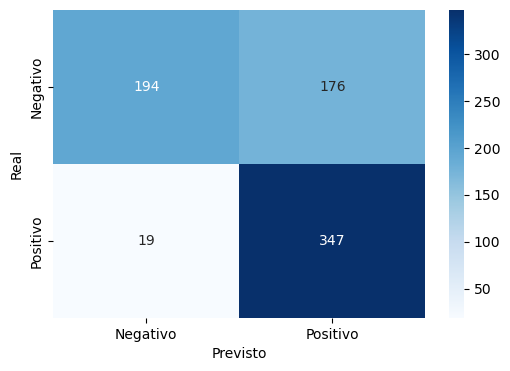

              precision    recall  f1-score   support

    Negativo       0.91      0.52      0.67       370
    Positivo       0.66      0.95      0.78       366

    accuracy                           0.74       736
   macro avg       0.79      0.74      0.72       736
weighted avg       0.79      0.74      0.72       736



In [14]:
# Avaliação

# Acurácia
test_loss, test_acc = model.evaluate(x_teste, y_teste, verbose=0)
print(f"Acurácia em teste: {test_acc * 100:.2f}%")

# Matriz de Confusão
y_pred = np.argmax(model.predict(x_teste), axis=1)
y_true = np.argmax(y_teste, axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

# Relatório de Classificação
print(classification_report(y_true, y_pred, target_names=["Negativo", "Positivo"]))

1/1 [==============================] - 0s 211ms/step


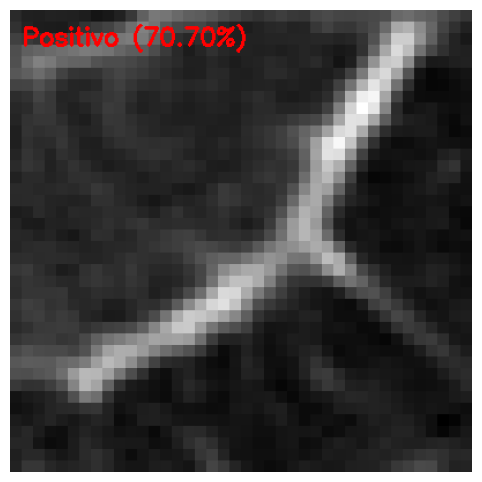

In [10]:
# Teste com imagem 1

image_path = "./dados/teste/imagem1_cancer.png"  # Exemplo: nome deve conter "pos" ou "neg"
image = cv2.imread(image_path)
orig = image.copy()

# Pré-processamento
image = cv2.resize(image, (40, 40))
image = image.astype("float32") / 255.0
image = np.expand_dims(image, axis=0)

# Predição
pred = model.predict(image)
label = "Positivo" if np.argmax(pred) == 1 else "Negativo"
proba = np.max(pred) * 100

# Exibição
output = imutils.resize(orig, width=400)
text = f"{label} ({proba:.2f}%)"
color = (0, 255, 0) if proba > 95 else (0, 0, 255)

cv2.putText(output, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

1/1 [==============================] - 0s 55ms/step


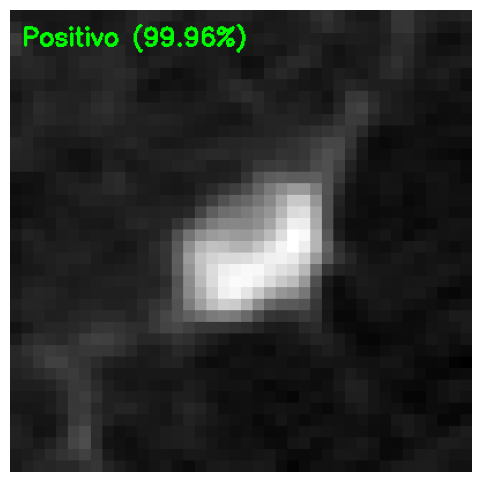

In [11]:
# Teste com imagem 2

image_path = "./dados/teste/imagem2_cancer.png"  # Exemplo: nome deve conter "pos" ou "neg"
image = cv2.imread(image_path)
orig = image.copy()

# Pré-processamento
image = cv2.resize(image, (40, 40))
image = image.astype("float32") / 255.0
image = np.expand_dims(image, axis=0)

# Predição
pred = model.predict(image)
label = "Positivo" if np.argmax(pred) == 1 else "Negativo"
proba = np.max(pred) * 100

# Exibição
output = imutils.resize(orig, width=400)
text = f"{label} ({proba:.2f}%)"
color = (0, 255, 0) if proba > 95 else (0, 0, 255)

cv2.putText(output, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

1/1 [==============================] - 0s 90ms/step


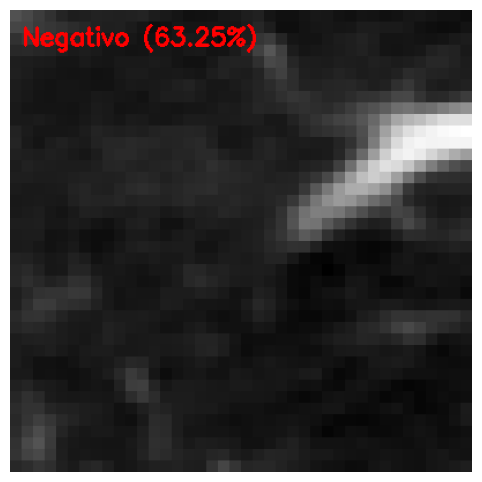

In [12]:
# Teste com imagem 3

image_path = "./dados/teste/imagem3_no_cancer.png"  # Exemplo: nome deve conter "pos" ou "neg"
image = cv2.imread(image_path)
orig = image.copy()

# Pré-processamento
image = cv2.resize(image, (40, 40))
image = image.astype("float32") / 255.0
image = np.expand_dims(image, axis=0)

# Predição
pred = model.predict(image)
label = "Positivo" if np.argmax(pred) == 1 else "Negativo"
proba = np.max(pred) * 100

# Exibição
output = imutils.resize(orig, width=400)
text = f"{label} ({proba:.2f}%)"
color = (0, 255, 0) if proba > 95 else (0, 0, 255)

cv2.putText(output, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

1/1 [==============================] - 0s 50ms/step


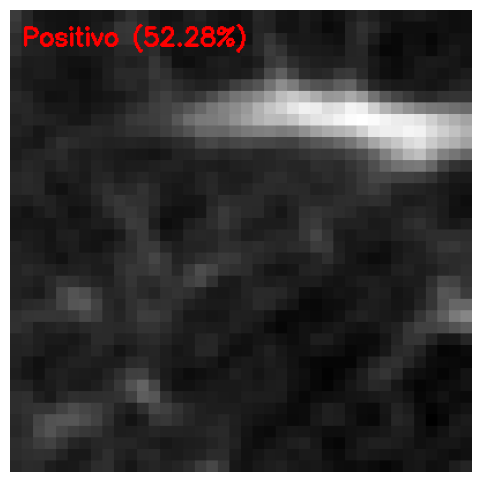

In [13]:
# Teste com imagem 4

image_path = "./dados/teste/imagem4_no_cancer.png"  # Exemplo: nome deve conter "pos" ou "neg"
image = cv2.imread(image_path)
orig = image.copy()

# Pré-processamento
image = cv2.resize(image, (40, 40))
image = image.astype("float32") / 255.0
image = np.expand_dims(image, axis=0)

# Predição
pred = model.predict(image)
label = "Positivo" if np.argmax(pred) == 1 else "Negativo"
proba = np.max(pred) * 100

# Exibição
output = imutils.resize(orig, width=400)
text = f"{label} ({proba:.2f}%)"
color = (0, 255, 0) if proba > 95 else (0, 0, 255)

cv2.putText(output, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [17]:
# Gerar arquivo de modelo

from tensorflow.keras.models import save_model

# Define o caminho do arquivo
model_path = "./modelo/modelo_treinado.keras"

# Salva o modelo
save_model(model, model_path)

# Verifica se o arquivo foi criado
import os
if os.path.exists(model_path):
    print(f"Modelo salvo com sucesso em: {model_path}")
else:
    print("Erro ao salvar o modelo!")

Modelo salvo com sucesso em: ./modelo/modelo_treinado.keras
